## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
import torch
import torch.nn.functional as F
import torchinfo
import torchvision.transforms as T
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.semantic_segmentation.datasets.voc import (LABEL_COLORS,
                                                          VocSegmentation)
from torchlake.semantic_segmentation.models import DeepLab

from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/deeplab")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 16
TRAIN_IMAGE_SIZE = 321 # 32k-31
TEST_IMAGE_SIZE = 513 # 32k-31
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
class DownScaleTransform(torch.nn.Module):
    def __init__(self, scale_factor: float):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.interpolate(
            x.expand(1, 1, *x.shape),
            size=TRAIN_IMAGE_SIZE // self.scale_factor + 1,
            mode='nearest',
        ).squeeze()

In [6]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

train_label_transform = T.Compose(
    [
        DownScaleTransform(8),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [7]:
train_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
    label_transform=train_label_transform,
)

test_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [8]:
NUM_WORKERS = get_num_workers()

In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

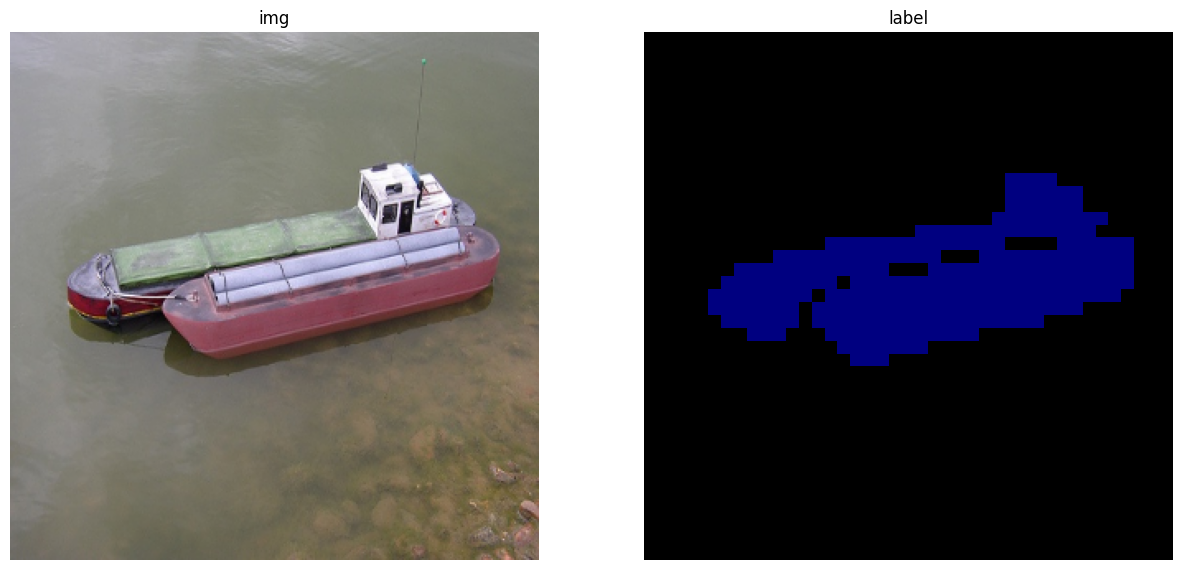

In [10]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# train

In [11]:
model = DeepLab(NUM_CLASS + 1, frozen_backbone=True).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
DeepLab                                       --
├─VGGFeatureExtractor: 1-1                    --
│    └─ImageNetNormalization: 2-1             --
│    └─Sequential: 2-2                        --
│    │    └─Conv2d: 3-1                       (1,792)
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       (36,928)
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       (73,856)
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       (147,584)
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      (295,168)
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      (590,080)
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15  

In [13]:
EPOCHES = 10

In [14]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
training_loss = trainer.run(train_loader, model, optimizer, criterion)

100%|██████████| 91/91 [00:47<00:00,  1.90it/s]


epoch 1 : 0.03476203441783622


100%|██████████| 91/91 [00:45<00:00,  1.98it/s]


epoch 2 : 0.01822417441264286


100%|██████████| 91/91 [00:46<00:00,  1.97it/s]


epoch 3 : 0.014729312661994289


100%|██████████| 91/91 [00:49<00:00,  1.82it/s]


epoch 4 : 0.012972146937889712


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


epoch 5 : 0.011885679163202479


100%|██████████| 91/91 [00:47<00:00,  1.92it/s]


epoch 6 : 0.011060494658342758


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 7 : 0.010298719199804159


100%|██████████| 91/91 [00:42<00:00,  2.15it/s]


epoch 8 : 0.00974799998125041


100%|██████████| 91/91 [00:47<00:00,  1.91it/s]


epoch 9 : 0.009166699373623827


100%|██████████| 91/91 [00:49<00:00,  1.84it/s]

epoch 10 : 0.008709976920387247


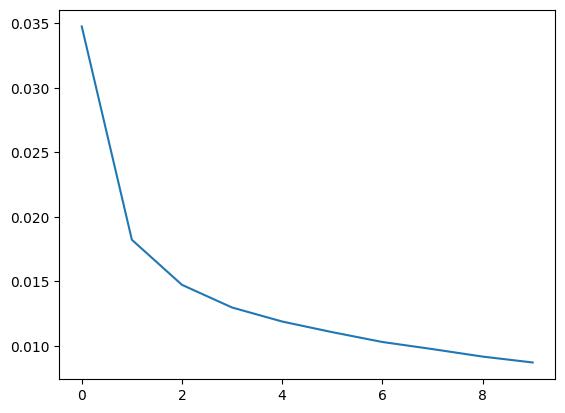

In [18]:
plt.plot(training_loss)

In [13]:
model_path = artifacts_path.joinpath('deeplab.pth')

In [20]:
torch.save(model.state_dict(), model_path)

In [21]:
get_file_size(model_path)

'82.85MiB'

In [14]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### dice coef

In [86]:
# from torchmetrics.classification import jaccard

In [15]:
# metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1)

model.eval()
with torch.no_grad():
    dice = {class_idx: [] for class_idx in range(21)}
    for img, labels in tqdm(test_loader):
        img = img.cuda()

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        img = img.detach().cpu()

        for class_idx in range(21):
            coef = 2 * (output.eq(class_idx) * labels.eq(class_idx)).sum() / (1 + output.eq(class_idx).sum() + labels.eq(class_idx).sum())
            dice[class_idx].append(coef) 
        # metric.update(output, labels)

for k, v in dice.items():
  dice[k] = np.mean(v)

100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


In [88]:
# metric.compute()

tensor(0.4345)

In [16]:
dice.pop(0, "")

# show dice of each category
for k, v in dice.items():
    print(VOC_CLASS_NAMES[k-1], v)

# show all
print("mean dice:", np.mean(list(dice.values())))

aeroplane 0.4449471
bicycle 0.14459212
bird 0.4287455
boat 0.36502504
bottle 0.27239457
bus 0.3884448
car 0.42222363
cat 0.54985726
chair 0.18488577
cow 0.34941655
diningtable 0.32535765
dog 0.46276665
horse 0.41957006
motorbike 0.45358866
person 0.77998817
pottedplant 0.1491014
sheep 0.3618072
sofa 0.24288364
train 0.44505492
tvmonitor 0.36994785
mean dice: 0.37802997


### for image in dataset

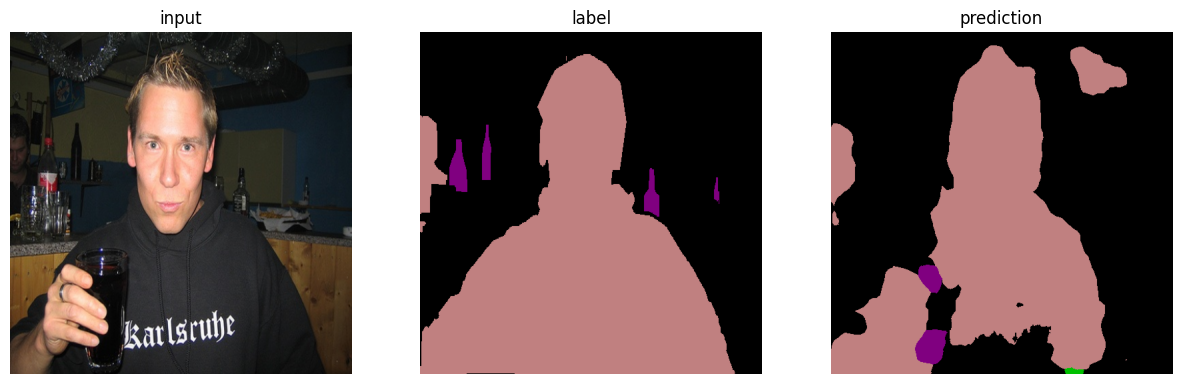

In [17]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

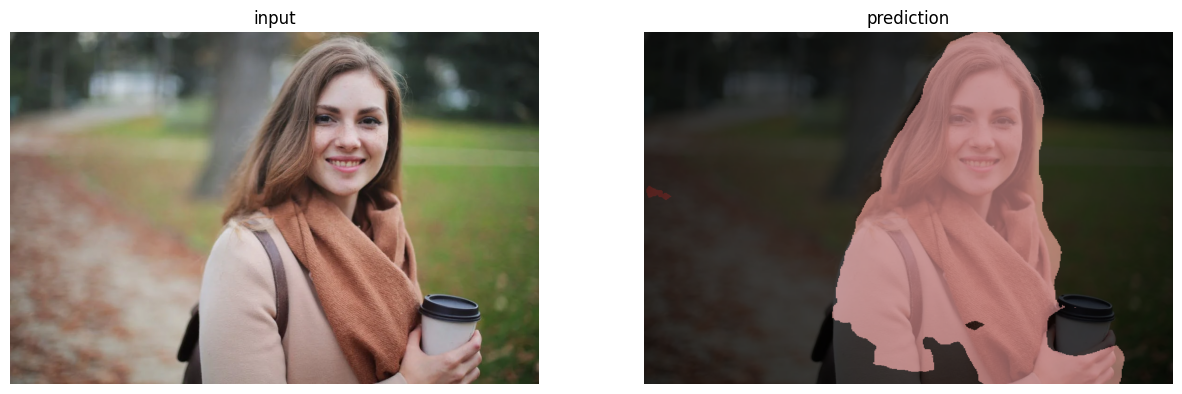

In [18]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )